# Optimization

## Evaluating Grid Search Results

A common practice in Machine Learning is to train several models with different hyperparameters and compare the performance across hyperparameter sets.
`scikit-learn` provides a tool to do it: `sklearn.grid_search.GridSearchCV`, which trains the same model with different parameters. 
When doing grid search, it is tempting to just take the ‘best model’ and carry on, but analyzing the results can give us some interesting information, so it’s worth taking a look at the results.

sklearn-evaluation includes a plotting function to evaluate grid search results, this way we can see how the model performs when changing one (or two) hyperparameter(s) by keeping the rest constant.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn_evaluation import plot

### Prepare data

First, let’s load some data.

In [2]:
data = datasets.make_classification(
    n_samples=200, n_features=10, n_informative=4, class_sep=0.5
)

X = data[0]
y = data[1]

### Perform Grid Search

Now, we need to define which hyperparameter sets we want to include in the grid search, we do so by defining a dictionary with hyperparameter-values pairs and scikit-learn will automatically generate all possible combinations. For the dictionary below, we can generate 16 combinations (4x2x2).

In [3]:
hyperparameters = {
    "n_estimators": [1, 10, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2"],
}

To perform a grid search we first need to select an estimator, in this case a Random Forest, then use the GridSearchCV class to pass the estimator, the hyperparameter dictionary and the number of folds for cross-validation.

After fitting the models (note that we call fit on the GridSearchCV instead of the estimator itself) we can get the results using the `sklearn.grid_search.GridSearchCV.cv_results_` attribute.

In [4]:
est = RandomForestClassifier(n_estimators=5)
clf = GridSearchCV(est, hyperparameters, cv=3)
clf.fit(X, y)

grid_scores = clf.cv_results_

### Visualise results

To generate the plot, we need to pass the grid_scores and the parameter(s) to change, let’s see how the number of trees in the Random Forest affects the performance of the model. We can also subset the grid scores to plot by using the subset parameter (note that the hyperparameter in change can also appear in subset).

<Axes: title={'center': 'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

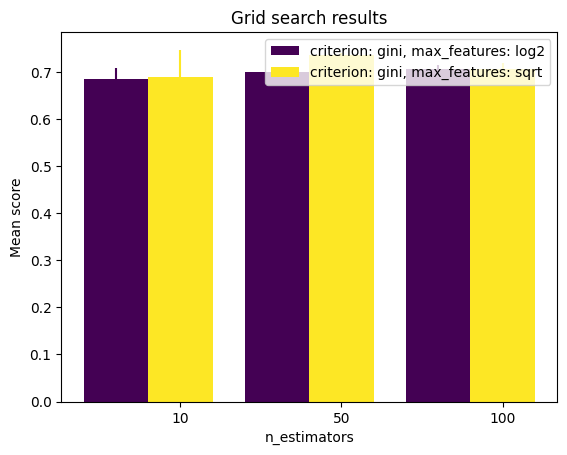

In [5]:
plot.grid_search(
    clf.cv_results_,
    change="n_estimators",
    subset={"n_estimators": [10, 50, 100], "criterion": "gini"},
    kind="bar",
)

To evaluate the effect of two hyperparameters, we pass the two of them in change, note that for this to work we need to subset the grid scores to match only one group. In this case we’ll plot n_estimators and criterion, so we need to subset max_features to one single value.

<Axes: >

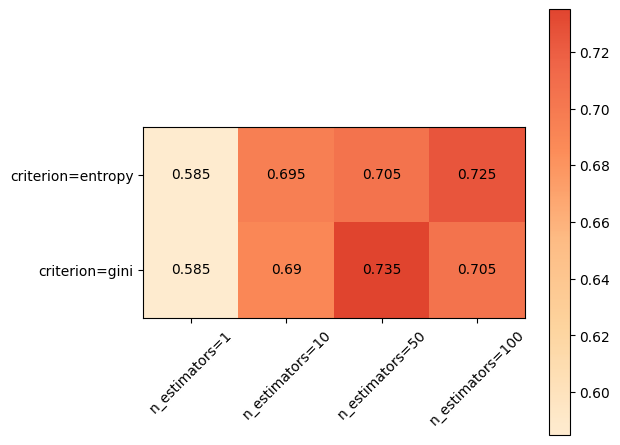

In [6]:
plot.grid_search(
    clf.cv_results_,
    change=("n_estimators", "criterion"),
    subset={"max_features": "sqrt"},
)

## Automated Grid Search

When manually tuning hyperparameters, defining the grid of values is time-consuming since we need to look at the parameters, read the docs and define the values we want to try. 

In this guide we will show you how to automate this process with our pre made grids and quickly find the optimal set of hyperparameters using our RandomForestClassifierGrid.

### Prepare the data

First things first, let's prepare our data.

Here we are going to use the HeartDiseasesUCI dataset.

In [7]:
import urllib.request
import pandas as pd

# download dataset
# Reference: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/sharmaroshan/Heart-UCI-Dataset/master/heart.csv",
    filename="heart.csv",
)

data = pd.read_csv("heart.csv")

data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

### Specify variables

In [8]:
X = data.drop("target", axis=1)

y = data["target"]

### Split the data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2023
)

### Initialize the model

Create a new `RandomForestClassifierGrid` and set which grid size you would like to run. 
You can choose any of the following sizes: `tiny`, `small`, `medium`, `large` or `xlarge`.

For this example we will use a tiny grid.

In [10]:
from sklearn_evaluation.grid import RandomForestClassifierGrid

model = RandomForestClassifierGrid(grid="tiny")

### Train all models

In [11]:
model.fit(X_train, y_train)

### Evaluate

`RandomForestClassifierGrid` uses `GridSearchCV` under the hood, we can easily access it via the `grid_search_cv_` attribute.

In [12]:
model.grid_search_cv_.best_params_

{'criterion': 'gini',
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

### Set test data

After the training is done we can set the test data, and evaluate our model using our out-of-the-box plots.

Please note that at the moment the plotting methods are using the GridSearchCV `best_estimator_ `.

In [13]:
model.set_test_data(X_test, y_test)

### Plots

You can use the below `grid_search_results` plot to visualize the results.

#### Grid search results

<Axes: title={'center': 'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

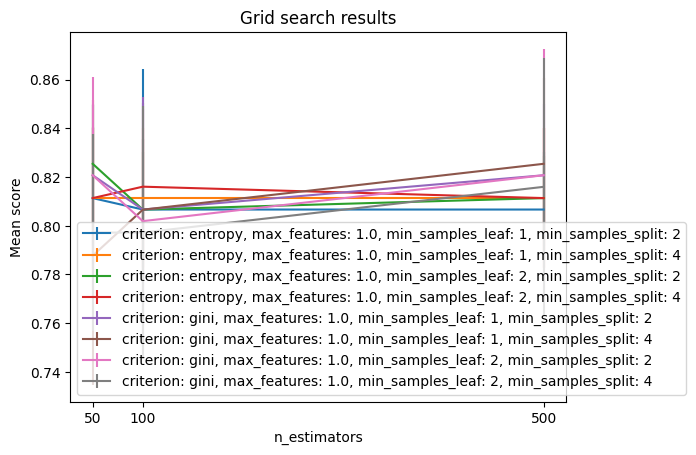

In [14]:
model.grid_search_results()

```{eval-rst}
.. tip::
   
   For more plots refer :class:`sklearn_evaluation.grid.RandomForestClassifierGrid`.

```